# Naive Bayes Classification - Email Spam Classifier

- Naive Bayes classification is a classification model, and therefore a supervised model
- Suppose we have a dataset with n features, (x1, x2, …, xn) and a class label, C. 
- Let's take some data involving spam text classification. 
- Our data would consist of rows of individual text samples and columns of both our features and our class labels. 
- Our features would be words and phrases that are contained within the text samples and our class labels are simply spam or not spam. 
- In this scenario, I will replace the not spam class with an easier-to-say word, ``ham''

**Use ``sklearn.naive_bayes`` to train a spam classifier! Most of the code is just loading training data into a pandas DataFrame that we can use for training the model.**

It assumes the presence of different words are independent of each other – one reason this is called “Naïve Bayes”.


In [1]:
import os
import io
import numpy
from pandas import DataFrame
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

import matplotlib.pyplot as plt
%matplotlib inline

- Generators are a special class of functions that simplify the task of writing iterators. 
- Regular functions compute a value and return it, but generators return an iterator that returns a stream of values
- Any function containing a **``yield`` keyword is a generator function**
- Refer to the docs for details https://docs.python.org/3/howto/functional.html

In [2]:
def readFiles(path):
    for root, dirnames, filenames in os.walk(path):
        for filename in filenames:
            path = os.path.join(root, filename)

            inBody = False
            lines = []
            f = io.open(path, 'r', encoding='latin1')
            ## Skip email header because we want msg body
            for line in f:
                if inBody:
                    lines.append(line)
                elif line == '\n':
                    inBody = True
            f.close()
            message = '\n'.join(lines)
            yield path, message

In [3]:
def dataFrameFromDirectory(path, classification):
    rows = []
    index = []
    for filename, message in readFiles(path):
        rows.append({'message': message, 'emailclass': classification})
        index.append(filename)

    return DataFrame(rows, index=index)

In [4]:
data = DataFrame({'message': [], 'emailclass': []})

data = data.append(dataFrameFromDirectory('emails/spam', 'spam'))
data = data.append(dataFrameFromDirectory('emails/ham', 'ham'))

Let's have a look at that DataFrame:

In [5]:
data.head()

,message,emailclass
emails/spam\00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",spam
emails/spam\00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,spam
emails/spam\00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,spam
emails/spam\00004.eac8de8d759b7e74154f142194282724,##############################################...,spam
emails/spam\00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,spam


In [6]:
data.emailclass.value_counts() / data.shape[0]

ham     0.833333
spam    0.166667
Name: emailclass, dtype: float64

## NOTE:
- We have way more ham messages than we do spam. Null accuracy rate is the percentage chance of predicting a single row correctly if we keep guessing the most common class (ham in this case). 
- So if we blindly guessed ham, we would be correct about 83% of the time, but we can do better than that.


- For example, imagine we have an email with three words: send cash now. We'll use **Naive Bayes to classify the email as either being spam or ham**
     - P(spam | send cash now) =  P(send cash now | spam) * P(spam) /  P(send cash now)
     - P(ham| send cash now) =  P(send cash now | ham) * P(ham) /  P(send cash now)

<AxesSubplot:>

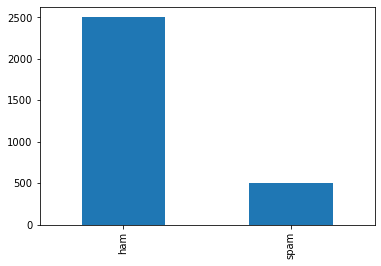

In [7]:
data.emailclass.value_counts().plot(kind="bar")

## Prepare the data for training Naive Bayes classifier
- **Use a CountVectorizer to split up each message into its list of words, and throw that into a MultinomialNB classifier (NB for Naive Bayes)**
- Essentially, it is getting a list of words in each email and the number of times that word occurs
- It represents each word seen in the message as numbers for compactness in a sparse matrix (words as numerical index)

In [8]:
vectorizer = CountVectorizer()
counts = vectorizer.fit_transform(data['message'].values)

In [9]:
dfcnt = DataFrame(counts.toarray(), columns=vectorizer.get_feature_names())
dfcnt.head()

,00,000,0000,000000,000000000,000000000000000000000,00000254,000033,000058,000066,...,þàì,þàìå,þàï,þàïà,þàïàº,þàïáö¼ò,þîñ,þõµ,þüg,ÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿó
0,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


- Call fit() and we've got a trained spam filter ready

In [10]:
classifier = MultinomialNB()
targets = data['emailclass'].values
classifier.fit(counts, targets)

MultinomialNB()

In [11]:
classifier.score(counts, targets)

0.9746666666666667

## Make predictions using the NB classifier

- Convert the message you want to predict in the same format as you used for training the model using CountVectorizer
- i.e. convert the message into list of words and frequencies

In [12]:
examples = ['Free Viagra now!!!']
example_counts = vectorizer.transform(examples)
predictions = classifier.predict(example_counts)
predictions

array(['spam'], dtype='<U4')

In [13]:
examples = ["Hi Bob, how about a game of golf tomorrow?"]
example_counts = vectorizer.transform(examples)
predictions = classifier.predict(example_counts)
predictions

array(['ham'], dtype='<U4')

In [14]:
DataFrame(example_counts.toarray())

,0,1,2,3,4,5,6,7,8,9,...,62954,62955,62956,62957,62958,62959,62960,62961,62962,62963
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## LAB 1 - Part 1

##### Our data set is small, so our spam classifier isn't actually very good. Try running some different test emails through it and see if you get the results you expect.

In [15]:
# Spam Example

example1 = [
    """Bonuses awarded from M&O Marketing on paid, issued business. For agent
        use only. Offer subject to change without notice. Offer starts 7/15/02.
        Offer ends 12/31/02. Offer good in all states except: WI, IN, DE. Not
        available with all carriers.

        We don't want anyone to receive our mailings who does not wish to
        receive them. This is a professional communication sent to insurance
        professionals. To be removed from this mailing list, DO NOT REPLY to
        this message"""
]
example1_counts = vectorizer.transform(example1)
predictions = classifier.predict(example1_counts)
predictions

array(['spam'], dtype='<U4')

In [16]:
# The above message has been taken from Spam folder and the model accurately predicted that it was a spam.

In [17]:
# Ham Example

example2 = [
    """I am wondering whether there's a way that I can use sitescooper and/or plucker
        or some other free utility to convert word documents into something a bit
        more palmos friendly?

        You could try antiword (http://www.winfield.demon.nl/linux/).
        It's consoled based and converts word 6+ docs to text and some images to
        postscript and png.  You could also try openoffice and/or abiword if you
        have x installed.

        I don't have a Windows machine, so it becomes problematic to convert them;
        I know that if this were not the case, in Word I could save them as some
        other more friendly format."""
]
example2_counts = vectorizer.transform(example2)
predictions = classifier.predict(example2_counts)
predictions

array(['ham'], dtype='<U4')

In [18]:
# The above message has been taken from ham folder and the model accurately predicted that it was a Ham.

##### Try applying train/test to this spam classifier - see how well it can predict some subset of the ham and spam emails. 

In [19]:
data['spam']=data['emailclass'].apply(lambda x: 1 if x=='spam' else 0)
data.head()

,message,emailclass,spam
emails/spam\00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",spam,1
emails/spam\00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,spam,1
emails/spam\00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,spam,1
emails/spam\00004.eac8de8d759b7e74154f142194282724,##############################################...,spam,1
emails/spam\00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,spam,1


In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.message,data.spam, test_size= 0.2,random_state=24)

In [21]:
from sklearn.pipeline import Pipeline
clf = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('nb', MultinomialNB())
])

In [22]:
clf.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', CountVectorizer()), ('nb', MultinomialNB())])

In [23]:
clf.score(X_test,y_test)

0.9816666666666667

In [24]:
clf.predict(example1)

array([1], dtype=int64)

In [25]:
# The output for the above example matches with my expectation as the email was accurately classified as SPAM

In [26]:
clf.predict(example2)

array([0], dtype=int64)

In [27]:
# The output for the above example matches with my expectation as the email was accurately classified as HAM